In [1]:
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import Weather_db
import Hobo_db
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pylab as py
from matplotlib import gridspec


In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
engine = create_engine('mysql+mysqlconnector://'+
                       Weather_db.user+
                       ':'+Weather_db.passwd+
                       '@localhost/'+
                       Weather_db.database, 
                       echo=False)

In [50]:
def makeCompare_Rain(serial, day=1):
    
    serial = str(serial)
    day = str(day)

    forecast = pd.read_sql_query("select serial, Rain_1, Rain_av3, day1_date from Forecasts", 
                         con=engine)
    forecast = forecast[(forecast.serial==serial)]
    forecast_day = forecast[["Rain_"+day, "Rain_av3", "day"+day+"_date"]]
    forecast_day = forecast_day.rename(columns={"Rain_"+day:"Rain", "day"+day+"_date":"date"})
    
    forecast_day = forecast_day.set_index("date")
    
    Rain_raw = "Rain_inch"
    ET_raw = "ETo_CIMIS_raw"
    if serial=='PH1' or serial=="PH2":
        Rain_raw = "`Rainfall.raw`"
        ET_raw = "`ETo.raw`"

    station = pd.read_sql_query("select Date, "+Rain_raw+" from "+serial+"_ETdata", con=engine)
    
    if serial=='PH1' or serial=="PH2":
        Rain_raw = "Rainfall.raw"
        ET_raw = "ETo.raw"
        
    station = station.rename(columns={Rain_raw:"Rain_raw", ET_raw:"Rain_raw"})
    
    
    station.Rain_raw[(station.Rain_raw==0)] = np.nan
    station['Date'] = pd.to_datetime(station['Date'])
    station = station.set_index('Date')

    evaluation = station.join(forecast_day, how='left').dropna()
    
    return evaluation

In [51]:
makeCompare_Rain('PH1')

<ipython-input-50-18282f697487>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station.Rain_raw[(station.Rain_raw==0)] = np.nan


,Rain_raw,Rain,Rain_av3
Date,,,
2021-07-12,0.01,0.046372,0.003333
2021-07-13,0.03,0.053205,0.003333
2021-07-14,0.01,0.063204,0.013333
2021-07-17,0.01,0.046293,0.003333
2021-07-18,0.01,0.053596,0.003333
2021-07-19,0.05,0.052898,0.006667
2021-07-20,0.03,0.069215,0.023333
2021-07-21,0.01,0.071204,0.030000
2021-08-03,0.01,0.045209,0.000000


In [52]:
def makeCompare(serial, day=1):
    
    serial = str(serial)
    day = str(day)

    forecast = pd.read_sql_query("select serial, ETo_av3, ETo_1, ETo_3, ETo_5, day1_date, day3_date, day5_date from Forecasts", 
                         con=engine)
    forecast = forecast[(forecast.serial==serial)]
    forecast_day = forecast[["ETo_"+day, "ETo_av3", "day"+day+"_date"]]
    forecast_day = forecast_day.rename(columns={"ETo_"+day:"ETo", "day"+day+"_date":"date"})
    
    forecast_day = forecast_day.set_index("date")
    
    ET_raw = "ETo_CIMIS_raw"
    if serial=='PH1' or serial=="PH2":
        ET_raw = "`ETo.raw`"

    station = pd.read_sql_query("select Date, "+ET_raw+" from "+serial+"_ETdata", con=engine)
    
    if serial=='PH1' or serial=="PH2":
        ET_raw = "ETo.raw"
        
    station = station.rename(columns={ET_raw:"ETo_raw"})
    
    
    station.ETo_raw[(station.ETo_raw==0)] = np.nan
    station['Date'] = pd.to_datetime(station['Date'])
    station = station.set_index('Date')

    evaluation = station.join(forecast_day, how='left').dropna()
    
    return evaluation

In [53]:
def metrics(y1, y2):
    '''
    y1 and y2 are two series of the same size

    This function outputs the MAE, RMSE and R^2 
    of the cross evaluated series.

    '''
    y1 = y1.reshape(-1)
    y2 = y2.reshape(-1)
    RMSE = np.sqrt(np.mean((y1-y2)**2))
    MAE = np.mean(np.abs(y1-y2))
    R21 = r2_score(y1, y2)
    R22 = r2_score(y2, y1)
    R2 = np.max([R21, R22])
    return 'MAE: %.2f\n'%MAE + 'RMSE: %.2f\n'%RMSE + 'R^2: %.2f'%R2
########################################

In [54]:
def pltAX(ax, serial, title='', Xlabel=False, day=1, quantity='ETo', xlim=[0.01,0.42], ylim=[0.01,0.42]):
    
    
    
    if quantity=='ETo':
        evaluation = makeCompare(serial, day=day)
    elif quantity=='Rain':
        evaluation = makeCompare_Rain(serial, day=day)
    else:
        return None
    
    X  = evaluation[quantity+'_raw'].values
    Yp = evaluation[quantity].values
    Y3 = evaluation[quantity+'_av3'].values

    pred = metrics(X, Yp)
    ave3 = metrics(X, Y3)
    
    if day == 1:
        ax.plot(X, Yp, 'g.', label='forecast '+str(day)+" day ahead")
    else:
        ax.plot(X, Yp, 'g.', label='forecast '+str(day)+" days ahead")
    ax.plot(X, Y3, 'r.', label='ave. last 3 days')

    ax.plot([0, 8], [0, 8], 'k-')

    ax.set_ylabel("Predicted "+quantity, fontsize=11)
    
    
    if not Xlabel:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.set_xlabel("Measured "+quantity, fontsize=11)

    set_axes(ax, xlim, ylim, fontsize=12)

    ax.legend(bbox_to_anchor =(1.02, 0.95), fontsize=10) 
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.90*Xlm[0]+1.1*Xlm[1]
    y0 = 0.5*Ylm[0]+0.5*Ylm[1] 
    ax.text(x0, y0, pred, color='g')
    y0 = 0.75*Ylm[0]+0.25*Ylm[1] 
    ax.text(x0, y0, ave3, color='r')
    
    ax.set_title(title, color='k', fontsize=10)

In [55]:
stationInfo = {
    '10906989': {"timeZone": "US/Hawaii", "Name": "ALOUN HELEMANO HOBO", "GPS": "21.5356N  -158.0343W"},
    '20173022': {"timeZone": "US/Hawaii", "Name": "HIRAKO HOBO", "GPS": "20.0036N  -155.6864W"},
    '20009161': {"timeZone": "US/Hawaii", "Name": "KULA AG PARK HOBO", "GPS": "20.7972N  -156.3599W"},
    '20121046': {"timeZone": "Pacific/Guam", "Name": "MALOJLOJ MEDA HOBO", "GPS": "13.31893N  144.76374E"},
    '20006321': {"timeZone": "US/Hawaii", "Name": "MA'O HOBO", "GPS": "21.4505N  -1581582W"},
    '20173020': {"timeZone": "US/Hawaii", "Name": "PIONEER CORN HOBO", "GPS": "21.5695N  -158.1561W"},
    '20173019': {"timeZone": "US/Hawaii", "Name": "SEIZEN HOBO", "GPS": "20.0264N  -155.6535W"},
    '20824841': {"timeZone": "Pacific/Guam", "Name": "WATSON HOBO", "GPS": "?"},
    '20824842': {"timeZone": "Pacific/Guam", "Name": "WUSSTIG HOBO", "GPS": "?"},
    '20121045': {"timeZone": "Pacific/Guam", "Name": "YIGO WATSO HOBO", "GPS": "13.5650N  144.8774E"},
    '20121047': {"timeZone": "Pacific/Samoa", "Name": "MALAEIMI HOBO", "GPS": "-14.1914S  -170.4425W"},
    '20121048': {"timeZone": "Pacific/Samoa", "Name": "TAFETA HOBO", "GPS": "-14.32095S  -170.754286W"},
    '20173018': {"timeZone": "US/Hawaii", "Name": "TEXEIRA HOBO", "GPS": "20.7952N  -156.3489W"},
    'PH1': {"timeZone": "US/Hawaii", "Name": "PIONEER GAY CAMPBELL", "GPS": "21.568543N  -158.155975W"},
    'PH2': {"timeZone": "US/Hawaii", "Name": "PIONEER HELENANO CAMPBELL", "GPS": "21.565335N  -158.097097W"},
}

<ipython-input-52-7945e69c7474>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station.ETo_raw[(station.ETo_raw==0)] = np.nan
<ipython-input-52-7945e69c7474>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station.ETo_raw[(station.ETo_raw==0)] = np.nan
<ipython-input-52-7945e69c7474>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station.ETo_raw[(station.ETo_raw==0)] = np.nan


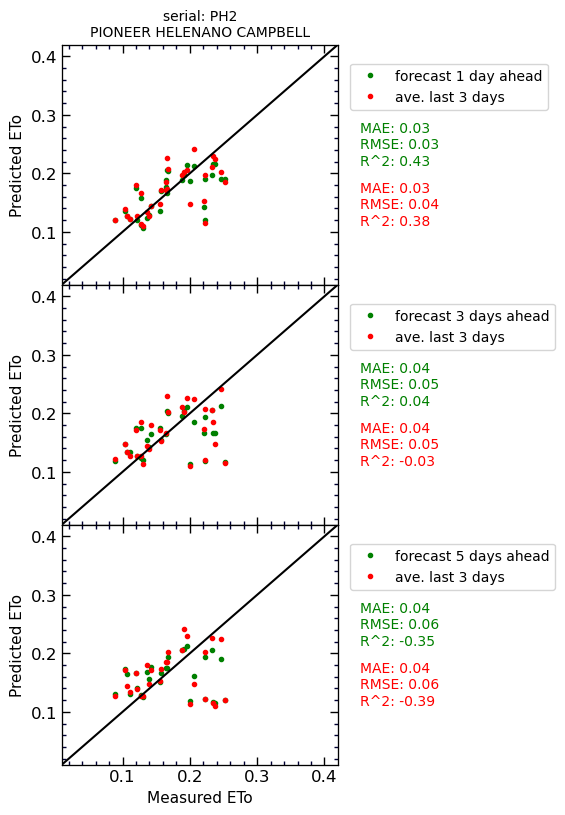

In [56]:
fig = py.figure(figsize=(3,9), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(3,1) ; p=0

serial = "PH2"

ax = plt.subplot(gs[p]) ; p+=1
pltAX(ax, serial, day=1, title='serial: '+str(serial)+"\n"+stationInfo[str(serial)]["Name"])

ax = plt.subplot(gs[p]) ; p+=1
pltAX(ax, serial, day=3)

ax = plt.subplot(gs[p]) ; p+=1
pltAX(ax, serial, Xlabel=True, day=5)

plt.subplots_adjust(hspace=0, wspace=0)

<ipython-input-50-18282f697487>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station.Rain_raw[(station.Rain_raw==0)] = np.nan


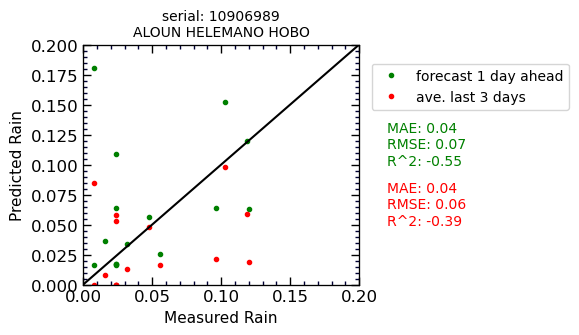

In [58]:
fig = py.figure(figsize=(3,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0

serial = 10906989

ax = plt.subplot(gs[p]) ; p+=1
pltAX(ax, serial, day=1, quantity='Rain', Xlabel=True,
          title='serial: '+str(serial)+"\n"+stationInfo[str(serial)]["Name"],
          xlim=[0.0,0.2],
          ylim=[0.0,0.2])

In [ ]:
engine.dispose()